#### Baseline:
Qwen2.5-Qwen2.5-Coder-7B-Instruct


📊 Accuracy by Task Type:

  Task Type  Accuracy
measurement    35.42%
 arithmetic    19.48%
    numbers    12.24%
 comparison    11.54%
    algebra    10.49%
   calculus     5.26%
polynomials     2.63%
probability     0.00%


/var/folders/gg/wqlmrvl91mj28lsltv0ccxqm0000gn/T/ipykernel_93006/3788320724.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_by_task_type.values, y=accuracy_by_task_type.index, palette='viridis')


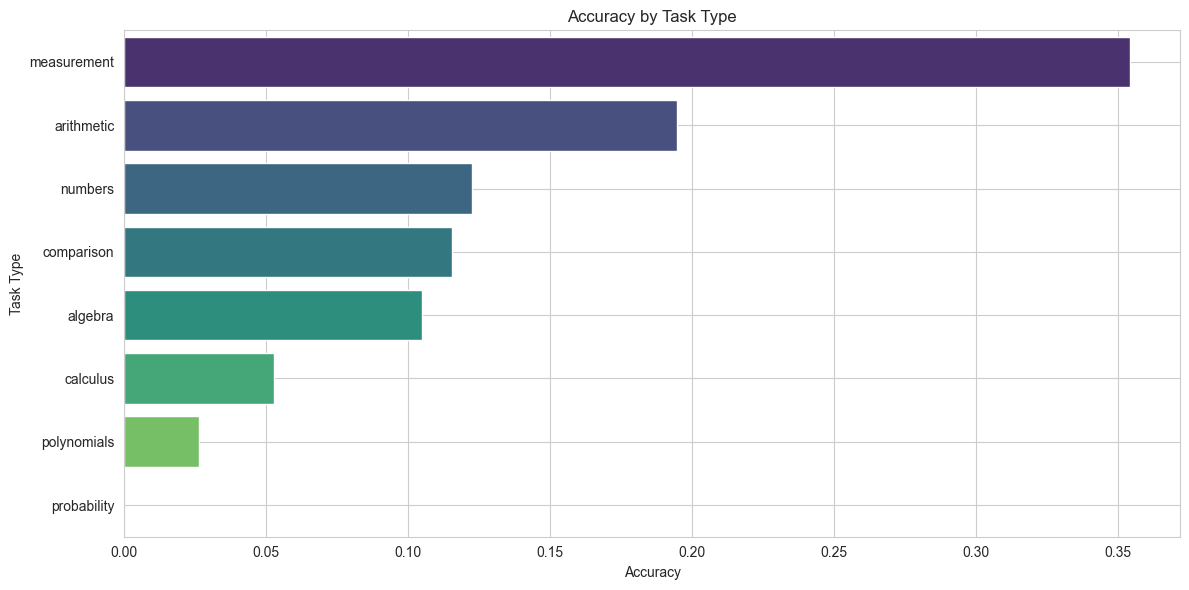


🔹 Total tasks: 1214
🔹 Raw accuracy: 12.19%
🔹 Adjusted accuracy (with float match errors): 13.67%
🔹 Float match errors (marked incorrect): 18
🔹 Empty answers: 0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../results/baseline/baseline_results.csv')

df['task_type'] = df['file'].apply(lambda x: x.split('__')[0] if '__' in x else x.split('.')[0])

def try_parse_float(value):
    try:
        return float(value)
    except:
        return None

df['gt_float'] = df['gt_answer'].apply(try_parse_float)
df['llm_float'] = df['llm_answer'].apply(try_parse_float)

total_tasks = len(df)

overall_accuracy = df['correct'].mean()
accuracy_by_task_type = df.groupby('task_type')['correct'].mean().sort_values(ascending=False)

float_match_errors = df[
    (~df['correct']) &
    (df['gt_float'].notna()) &
    (df['llm_float'].notna()) &
    (np.isclose(df['gt_float'], df['llm_float'], atol=1e-4))
]
num_float_match_errors = len(float_match_errors)

adjusted_correct = df['correct'].sum() + num_float_match_errors
adjusted_accuracy = adjusted_correct / total_tasks

num_empty_answers = df['llm_answer'].isna().sum() + (df['llm_answer'].astype(str).str.strip() == '').sum()

accuracy_table = accuracy_by_task_type.reset_index()
accuracy_table.columns = ['Task Type', 'Accuracy']
print("\n📊 Accuracy by Task Type:\n")
print(accuracy_table.to_string(index=False, float_format="{:.2%}".format))

plt.figure(figsize=(12, 6))
sns.barplot(x=accuracy_by_task_type.values, y=accuracy_by_task_type.index, palette='viridis')
plt.xlabel('Accuracy')
plt.ylabel('Task Type')
plt.title('Accuracy by Task Type')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'\n🔹 Total tasks: {total_tasks}')
print(f'🔹 Raw accuracy: {overall_accuracy:.2%}')
print(f'🔹 Adjusted accuracy (with float match errors): {adjusted_accuracy:.2%}')
print(f'🔹 Float match errors (marked incorrect): {num_float_match_errors}')
print(f'🔹 Empty answers: {num_empty_answers}')


#### Agent with code execution

In [ ]:
import importlib.util
import sys
import os
import glob
import matplotlib.pyplot as plt

script_path = "../eval_agent/get_error_statistic.py"
module_name = "get_error_statistic"

spec = importlib.util.spec_from_file_location(module_name, script_path)
module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)


In [55]:
folder = "../results/code_eval"
prefix = "train_"
pattern = os.path.join(folder, f"{prefix}*.json")
files = glob.glob(pattern)

print(f"🔍 Found: {len(files)}")

from collections import defaultdict

category_totals = defaultdict(lambda: defaultdict(int))

for filepath in files:
    stats, cuda_oom, too_many_steps, digits_error = module.analyze_file(filepath)
    for cat, data in stats.items():
        for key, value in data.items():
            category_totals[cat][key] += value


🔍 Found: 5


/var/folders/gg/wqlmrvl91mj28lsltv0ccxqm0000gn/T/ipykernel_93006/2387955351.py:29: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) Arial.
  plt.tight_layout()
/Users/diana/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


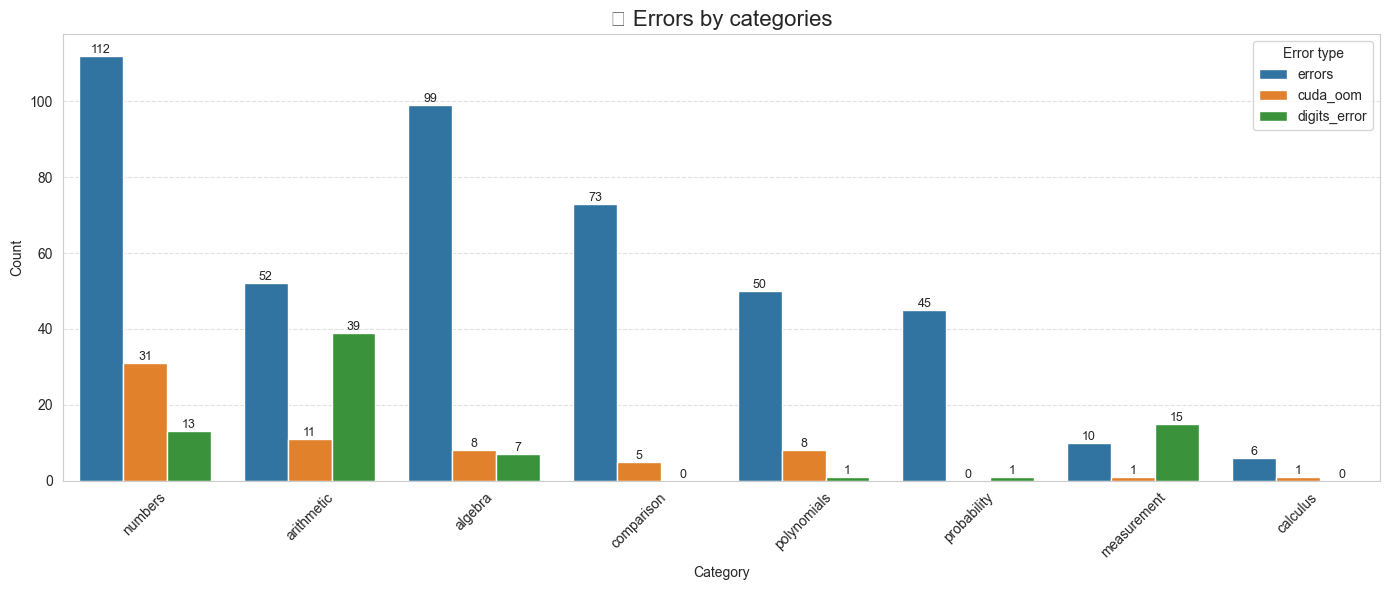

/var/folders/gg/wqlmrvl91mj28lsltv0ccxqm0000gn/T/ipykernel_93006/2387955351.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_table['total_errors'] = numeric_table[error_types].sum(axis=1)


,errors,cuda_oom,digits_error,total,total_errors
numbers,112,31,13,293,156
algebra,99,8,7,142,114
arithmetic,52,11,39,181,102
comparison,73,5,0,122,78
polynomials,50,8,1,111,59
probability,45,0,1,48,46
measurement,10,1,15,38,26
calculus,6,1,0,18,7


In [56]:
from IPython.display import display


df_stats = pd.DataFrame.from_dict(category_totals, orient='index')
df_stats = df_stats.sort_values('total', ascending=False)


error_types = ['errors', 'cuda_oom', 'digits_error']
df_stats_plot = df_stats[error_types].copy()
df_stats_plot['category'] = df_stats_plot.index
df_stats_plot = df_stats_plot.reset_index(drop=True)


plt.figure(figsize=(14, 6))
barplot = sns.barplot(
    data=pd.melt(df_stats_plot, id_vars='category', value_vars=error_types),
    x='category', y='value', hue='variable', palette='tab10'
)
plt.title("🧮 Errors by categories", fontsize=16)
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)


for container in barplot.containers:
    barplot.bar_label(container, fmt='%d', label_type='edge', fontsize=9)

plt.tight_layout()
plt.legend(title='Error type')
plt.show()


numeric_table = df_stats[error_types + ['total']]
numeric_table['total_errors'] = numeric_table[error_types].sum(axis=1)
numeric_table = numeric_table.sort_values('total_errors', ascending=False)

display(numeric_table)


Found: 5 JSON files in '../results/code_eval'

--- Numerical Table: Percentage of Correct Answers by Category ---

  accuracy_percentage     category
6              73.68%  measurement
1              71.27%   arithmetic
7              66.67%     calculus
0              61.77%      numbers
4              54.95%  polynomials
3              40.16%   comparison
2              30.28%      algebra
5               6.25%  probability




/var/folders/gg/wqlmrvl91mj28lsltv0ccxqm0000gn/T/ipykernel_93006/506975610.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot_accuracy = sns.barplot(


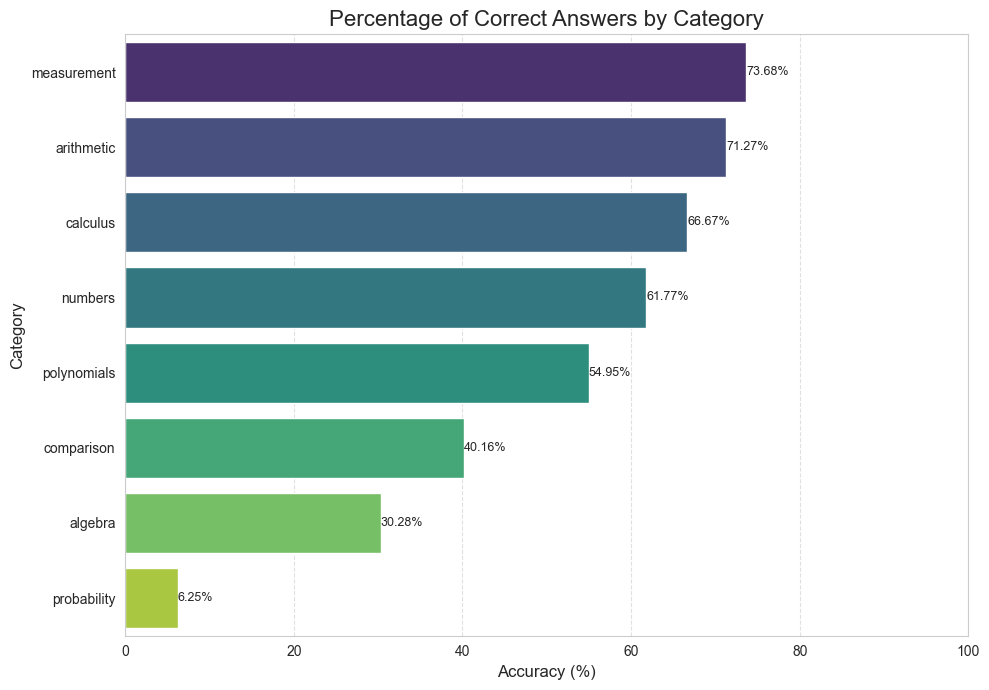

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib.util
import sys
import os
import glob
from collections import defaultdict

script_path = "../eval_agent/get_error_statistic.py"
module_name = "get_error_statistic"

try:
    spec = importlib.util.spec_from_file_location(module_name, script_path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
except FileNotFoundError:
    print(f"Error: The script '{script_path}' was not found.")
    print("Please ensure 'get_error_statistic.py' exists at the specified path as described in the instructions.")
    sys.exit(1) 
except Exception as e:
    print(f"Error loading module '{module_name}' from '{script_path}': {e}")
    sys.exit(1)

folder = "../results/code_eval"
prefix = "train_" 
pattern = os.path.join(folder, f"{prefix}*.json")
files = glob.glob(pattern)

if not files:
    print(f"No JSON files found matching pattern '{pattern}'. Please check the 'folder' and 'prefix' variables.")
    sys.exit(0) 

print(f"Found: {len(files)} JSON files in '{folder}'")


category_totals = defaultdict(lambda: defaultdict(int))
overall_cuda_oom_total = 0
overall_too_many_steps_total = 0
overall_digits_error_total = 0

for filepath in files:
    try:
        stats, cuda_oom, too_many_steps, digits_error = module.analyze_file(filepath)
        overall_cuda_oom_total += cuda_oom
        overall_too_many_steps_total += too_many_steps
        overall_digits_error_total += digits_error

        for cat, data in stats.items():
            for key, value in data.items():
                category_totals[cat][key] += value
    except Exception as e:
        print(f"Error processing file '{filepath}': {e}")
        continue 

df_stats = pd.DataFrame.from_dict(category_totals, orient='index')
for col in ['errors', 'cuda_oom', 'too_many_steps', 'equiv_errors', 'digits_error']:
    if col not in df_stats.columns:
        df_stats[col] = 0

if 'total' not in df_stats.columns:
    df_stats['total'] = 0

df_stats = df_stats.sort_values('total', ascending=False)

print("\n--- Numerical Table: Percentage of Correct Answers by Category ---\n")

df_stats['correct_count'] = df_stats['total'] - df_stats['errors']
df_stats['accuracy_percentage'] = (df_stats['correct_count'] / df_stats['total']) * 100
df_stats['accuracy_percentage'] = df_stats['accuracy_percentage'].fillna(0) 


accuracy_plot_df = df_stats[['accuracy_percentage']].copy()
accuracy_plot_df['category'] = accuracy_plot_df.index
accuracy_plot_df = accuracy_plot_df.reset_index(drop=True)
accuracy_plot_df = accuracy_plot_df.sort_values(by='accuracy_percentage', ascending=False)

accuracy_table_df = accuracy_plot_df.copy()
accuracy_table_df['accuracy_percentage'] = accuracy_table_df['accuracy_percentage'].apply(lambda x: f"{x:.2f}%")
print(accuracy_table_df.to_string())
print("\n" + "="*70 + "\n")


plt.figure(figsize=(10, 7))
barplot_accuracy = sns.barplot(
    data=accuracy_plot_df,
    x='accuracy_percentage', 
    y='category',            
    palette='viridis'        
)

plt.title("Percentage of Correct Answers by Category", fontsize=16)
plt.xlabel("Accuracy (%)", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.xlim(0, 100) 

for container in barplot_accuracy.containers:
    barplot_accuracy.bar_label(container, fmt='%.2f%%', label_type='edge', fontsize=9)

plt.grid(axis='x', linestyle='--', alpha=0.6) 
plt.tight_layout()
plt.show()

In [58]:
total_tasks = df_stats['total'].sum()
total_correct = df_stats['total'].sum() - df_stats['errors'].sum()
total_correct_with_equiv = total_correct + df_stats['digits_error'].sum()


accuracy = total_correct / total_tasks * 100
accuracy_with_equiv = total_correct_with_equiv / total_tasks * 100

print(f"✅ Total number: {total_tasks}")
print(f"✅ Correct answers: {total_correct} ({accuracy:.2f}%)")
print(f"✅ Correct with equivivalence for 25.0 and 25: {total_correct_with_equiv} ({accuracy_with_equiv:.2f}%)")


✅ Total number: 953
✅ Correct answers: 506 (53.10%)
✅ Correct with equivivalence for 25.0 and 25: 582 (61.07%)


In [59]:
import os, json
from math import isclose
from collections import defaultdict

def is_equivalent(a, b, tol=1e-6):
    try:
        return isclose(float(a), float(b), abs_tol=tol)
    except:
        return str(a).strip() == str(b).strip()


eval_folder = "../results/code_eval"
eval_files = glob.glob(os.path.join(eval_folder, "math_*.json"))

print(f"Found files: {len(eval_files)}")

# Статистика по всем файлам
overall_stats = defaultdict(int)

for file in eval_files:
    with open(file, "r") as f:
        data = json.load(f)
    
    stats = data.get("statistics", {})
    details = stats.get("details", [])

    overall_stats["total"] += stats.get("total", len(details))
    overall_stats["correct"] += stats.get("correct", 0)
    overall_stats["incorrect"] += stats.get("incorrect", 0)
    overall_stats["no_answer"] += stats.get("no_answer", 0)
    overall_stats["api_errors"] += stats.get("api_errors", 0)

    # Добавим "essentially correct"
    for item in details:
        expected = item.get("expected", "").strip()
        predicted = item.get("predicted", "").strip()
        verdict = item.get("verdict", "").upper()

        if verdict == "CORRECT":
            overall_stats["essentially_correct"] += 1
        elif is_equivalent(expected, predicted):
            overall_stats["essentially_correct"] += 1


Found files: 5


In [60]:
print("Statistic:")
for k, v in overall_stats.items():
    print(f"{k:25} {v}")


total = overall_stats["total"]
percent_correct = overall_stats["correct"] / total * 100

print(f"\n✅ Correct: {percent_correct:.2f}%")


Statistic:
total                     953
correct                   634
incorrect                 319
no_answer                 0
api_errors                1
essentially_correct       666

✅ Correct: 66.53%


#### Agent with code execution + feedback

Overall Metrics:



/var/folders/gg/wqlmrvl91mj28lsltv0ccxqm0000gn/T/ipykernel_93006/1016342257.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100.00%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  overall_metrics_df.loc['parsing_accuracy', 'Value'] = f"{overall_metrics_df.loc['parsing_accuracy', 'Value']:.2%}"


,Value
total_problems,1214.0
parsed_successfully,1214.0
correct_answers,852.0
errors,0.0
parsing_accuracy,100.00%
solving_accuracy,70.18%
conditional_accuracy,70.18%




Category-wise Accuracy:



/var/folders/gg/wqlmrvl91mj28lsltv0ccxqm0000gn/T/ipykernel_93006/1016342257.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Category', data=category_df, palette='viridis')


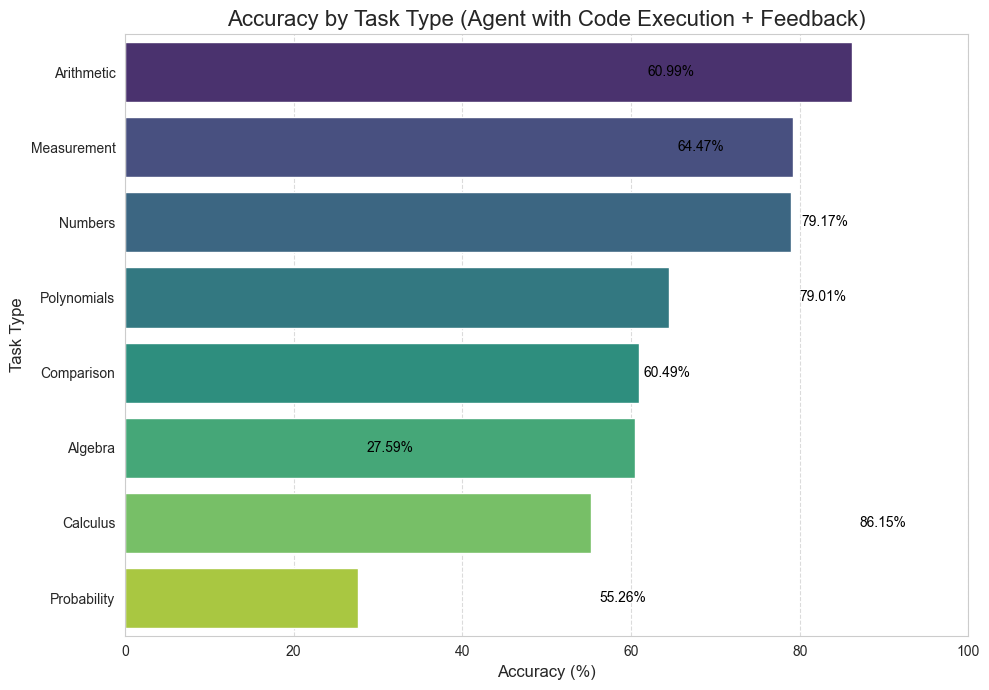


--- Numerical Output: Category-wise Statistics ---



,Category,Total Problems,Correct Answers,Errors,Parsed Successfully,Parsing Accuracy,Solving Accuracy,Conditional Accuracy
6,Arithmetic,231,199,0,231,100.00%,86.15%,86.15%
2,Measurement,48,38,0,48,100.00%,79.17%,79.17%
3,Numbers,343,271,0,343,100.00%,79.01%,79.01%
1,Polynomials,152,98,0,152,100.00%,64.47%,64.47%
0,Comparison,182,111,0,182,100.00%,60.99%,60.99%
4,Algebra,162,98,0,162,100.00%,60.49%,60.49%
7,Calculus,38,21,0,38,100.00%,55.26%,55.26%
5,Probability,58,16,0,58,100.00%,27.59%,27.59%





Detailed Results (first 5 entries):



,problem,expected_answer,predicted_answer,correct,parsed_successfully,category,split
0,Let u(f) = -f - 4. Let g be u(-4). Let j = 1.2...,c,c,True,True,comparison,train-easy
1,Let q = -0.9 + -3. Let f = q - -4. Let j = 0.0...,a,f,False,True,comparison,train-easy
2,Let i be 0 + -1 + (-19)/(-21). Let p = -0.5 - ...,c,c,True,True,comparison,train-easy
3,Suppose -j = 2*j - 357. Let q = j + -1189/10. ...,False,False,True,True,comparison,train-easy
4,Let m = -6 + 8. Let p = -19/2 + 10. Do p and m...,True,True,True,True,comparison,train-easy


In [48]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display 

file_path = '../results/agent_comprehensive_evaluation_results.json'

try:
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    print("Overall Metrics:\n")
    overall_metrics_df = pd.DataFrame([data['overall_metrics']]).T
    overall_metrics_df.columns = ['Value']

    overall_metrics_df.loc['parsing_accuracy', 'Value'] = f"{overall_metrics_df.loc['parsing_accuracy', 'Value']:.2%}"
    overall_metrics_df.loc['solving_accuracy', 'Value'] = f"{overall_metrics_df.loc['solving_accuracy', 'Value']:.2%}"
    overall_metrics_df.loc['conditional_accuracy', 'Value'] = f"{overall_metrics_df.loc['conditional_accuracy', 'Value']:.2%}"

    display(overall_metrics_df) 
    print("\n" + "="*50 + "\n") 

    print("Category-wise Accuracy:\n")

    category_data = []
    for category, metrics in data['category_metrics'].items():
        category_data.append({
            'Category': category.capitalize(), 
            'Accuracy': metrics['solving_accuracy'] * 100 
        })

    category_df = pd.DataFrame(category_data)

    category_df = category_df.sort_values(by='Accuracy', ascending=False)

    plt.figure(figsize=(10, 7)) 
    sns.barplot(x='Accuracy', y='Category', data=category_df, palette='viridis')

    plt.title('Accuracy by Task Type (Agent with Code Execution + Feedback)', fontsize=16)
    plt.xlabel('Accuracy (%)', fontsize=12)
    plt.ylabel('Task Type', fontsize=12)
    plt.xlim(0, 100) 

    
    for index, row in category_df.iterrows():
        plt.text(row['Accuracy'] + 1, index, f"{row['Accuracy']:.2f}%", color='black', ha="left", va='center', fontsize=10)

    plt.grid(axis='x', linestyle='--', alpha=0.7) 
    plt.tight_layout() 
    plt.show()

    print("\n--- Numerical Output: Category-wise Statistics ---\n")

    full_category_metrics = []
    for category, metrics in data['category_metrics'].items():
        row = {'Category': category.capitalize()}
        for key, value in metrics.items():
            if 'accuracy' in key:
                row[key.replace('_', ' ').title()] = f"{value:.2%}" 
            else:
                row[key.replace('_', ' ').title()] = value 
        full_category_metrics.append(row)

    full_category_df = pd.DataFrame(full_category_metrics)
    
    column_order = [
        'Category', 'Total Problems', 'Correct Answers', 'Errors', 
        'Parsed Successfully', 'Parsing Accuracy', 'Solving Accuracy', 'Conditional Accuracy'
    ]
    full_category_df = full_category_df[column_order]
    
    full_category_df['Solving Accuracy Value'] = full_category_df['Solving Accuracy'].str.rstrip('%').astype(float)
    full_category_df = full_category_df.sort_values(by='Solving Accuracy Value', ascending=False)
    full_category_df = full_category_df.drop(columns='Solving Accuracy Value')


    display(full_category_df) 
    
    print("\n" + "="*50 + "\n")


    print("\nDetailed Results (first 5 entries):\n")
    detailed_results_df = pd.DataFrame(data['detailed_results'])
    display(detailed_results_df.head())


except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure the file exists and the path is correct.")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from '{file_path}'. Please check if the file contains valid JSON.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


In [53]:
import os, json
from math import isclose
from collections import defaultdict

def is_equivalent(a, b, tol=1e-6):
    try:
        return isclose(float(a), float(b), abs_tol=tol)
    except:
        return str(a).strip() == str(b).strip()


eval_folder = "../results"
eval_files = glob.glob(os.path.join(eval_folder, "fb_gemini_eval.json"))

print(f"Found files: {len(eval_files)}")

# Статистика по всем файлам
overall_stats = defaultdict(int)

for file in eval_files:
    with open(file, "r") as f:
        data = json.load(f)
    
    stats = data.get("statistics", {})
    details = stats.get("details", [])

    overall_stats["total"] += stats.get("total", len(details))
    overall_stats["correct"] += stats.get("correct", 0)
    overall_stats["incorrect"] += stats.get("incorrect", 0)
    overall_stats["no_answer"] += stats.get("no_answer", 0)
    overall_stats["api_errors"] += stats.get("api_errors", 0)

    for item in details:
        expected = item.get("expected", "").strip()
        predicted = item.get("predicted", "").strip()
        verdict = item.get("verdict", "").upper()

        if verdict == "CORRECT":
            overall_stats["essentially_correct"] += 1
        elif is_equivalent(expected, predicted):
            overall_stats["essentially_correct"] += 1


Found files: 1


In [54]:
print("Statistic:")
for k, v in overall_stats.items():
    print(f"{k:25} {v}")


total = overall_stats["total"]
percent_correct = overall_stats["correct"] / total * 100

print(f"\n✅ Correct: {percent_correct:.2f}%")


Statistic:
total                     1214
correct                   1029
incorrect                 185
no_answer                 0
api_errors                0
essentially_correct       1753

✅ Correct: 84.76%
